<a href="https://colab.research.google.com/github/Andres8bit/Machine-Learning/blob/main/Style_transfer_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image,display
from tensorflow.keras.applications import vgg19
from google.colab import drive
drive.mount('/content/drive')
 
#base_image_path = keras.utils.get_file("paris.jpg", "https://i.imgur.com/F28w3Ac.jpg")
base_image_path = keras.utils.get_file( "mac.jpg","https://i.imgur.com/TvmSvSh.jpg")
style_reference_image_path = keras.utils.get_file(
   "starry_night.jpg", "https://i.imgur.com/knE2dQx.jpg"
)

# style_reference_image_path = keras.utils.get_file(
#     "scan.jpg", "https://imgur.com/0tLXUdh.jpg"
# )

result = "paris_generated"
variation_weight = 1e-6
style_weight = 1.5e-6
content_weight = 2.5e-8

width,height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width*img_nrows/height)





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
16384/13585 [====================================] - 0s 0us/step


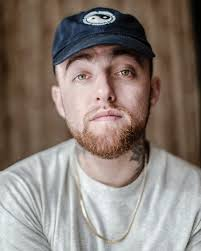

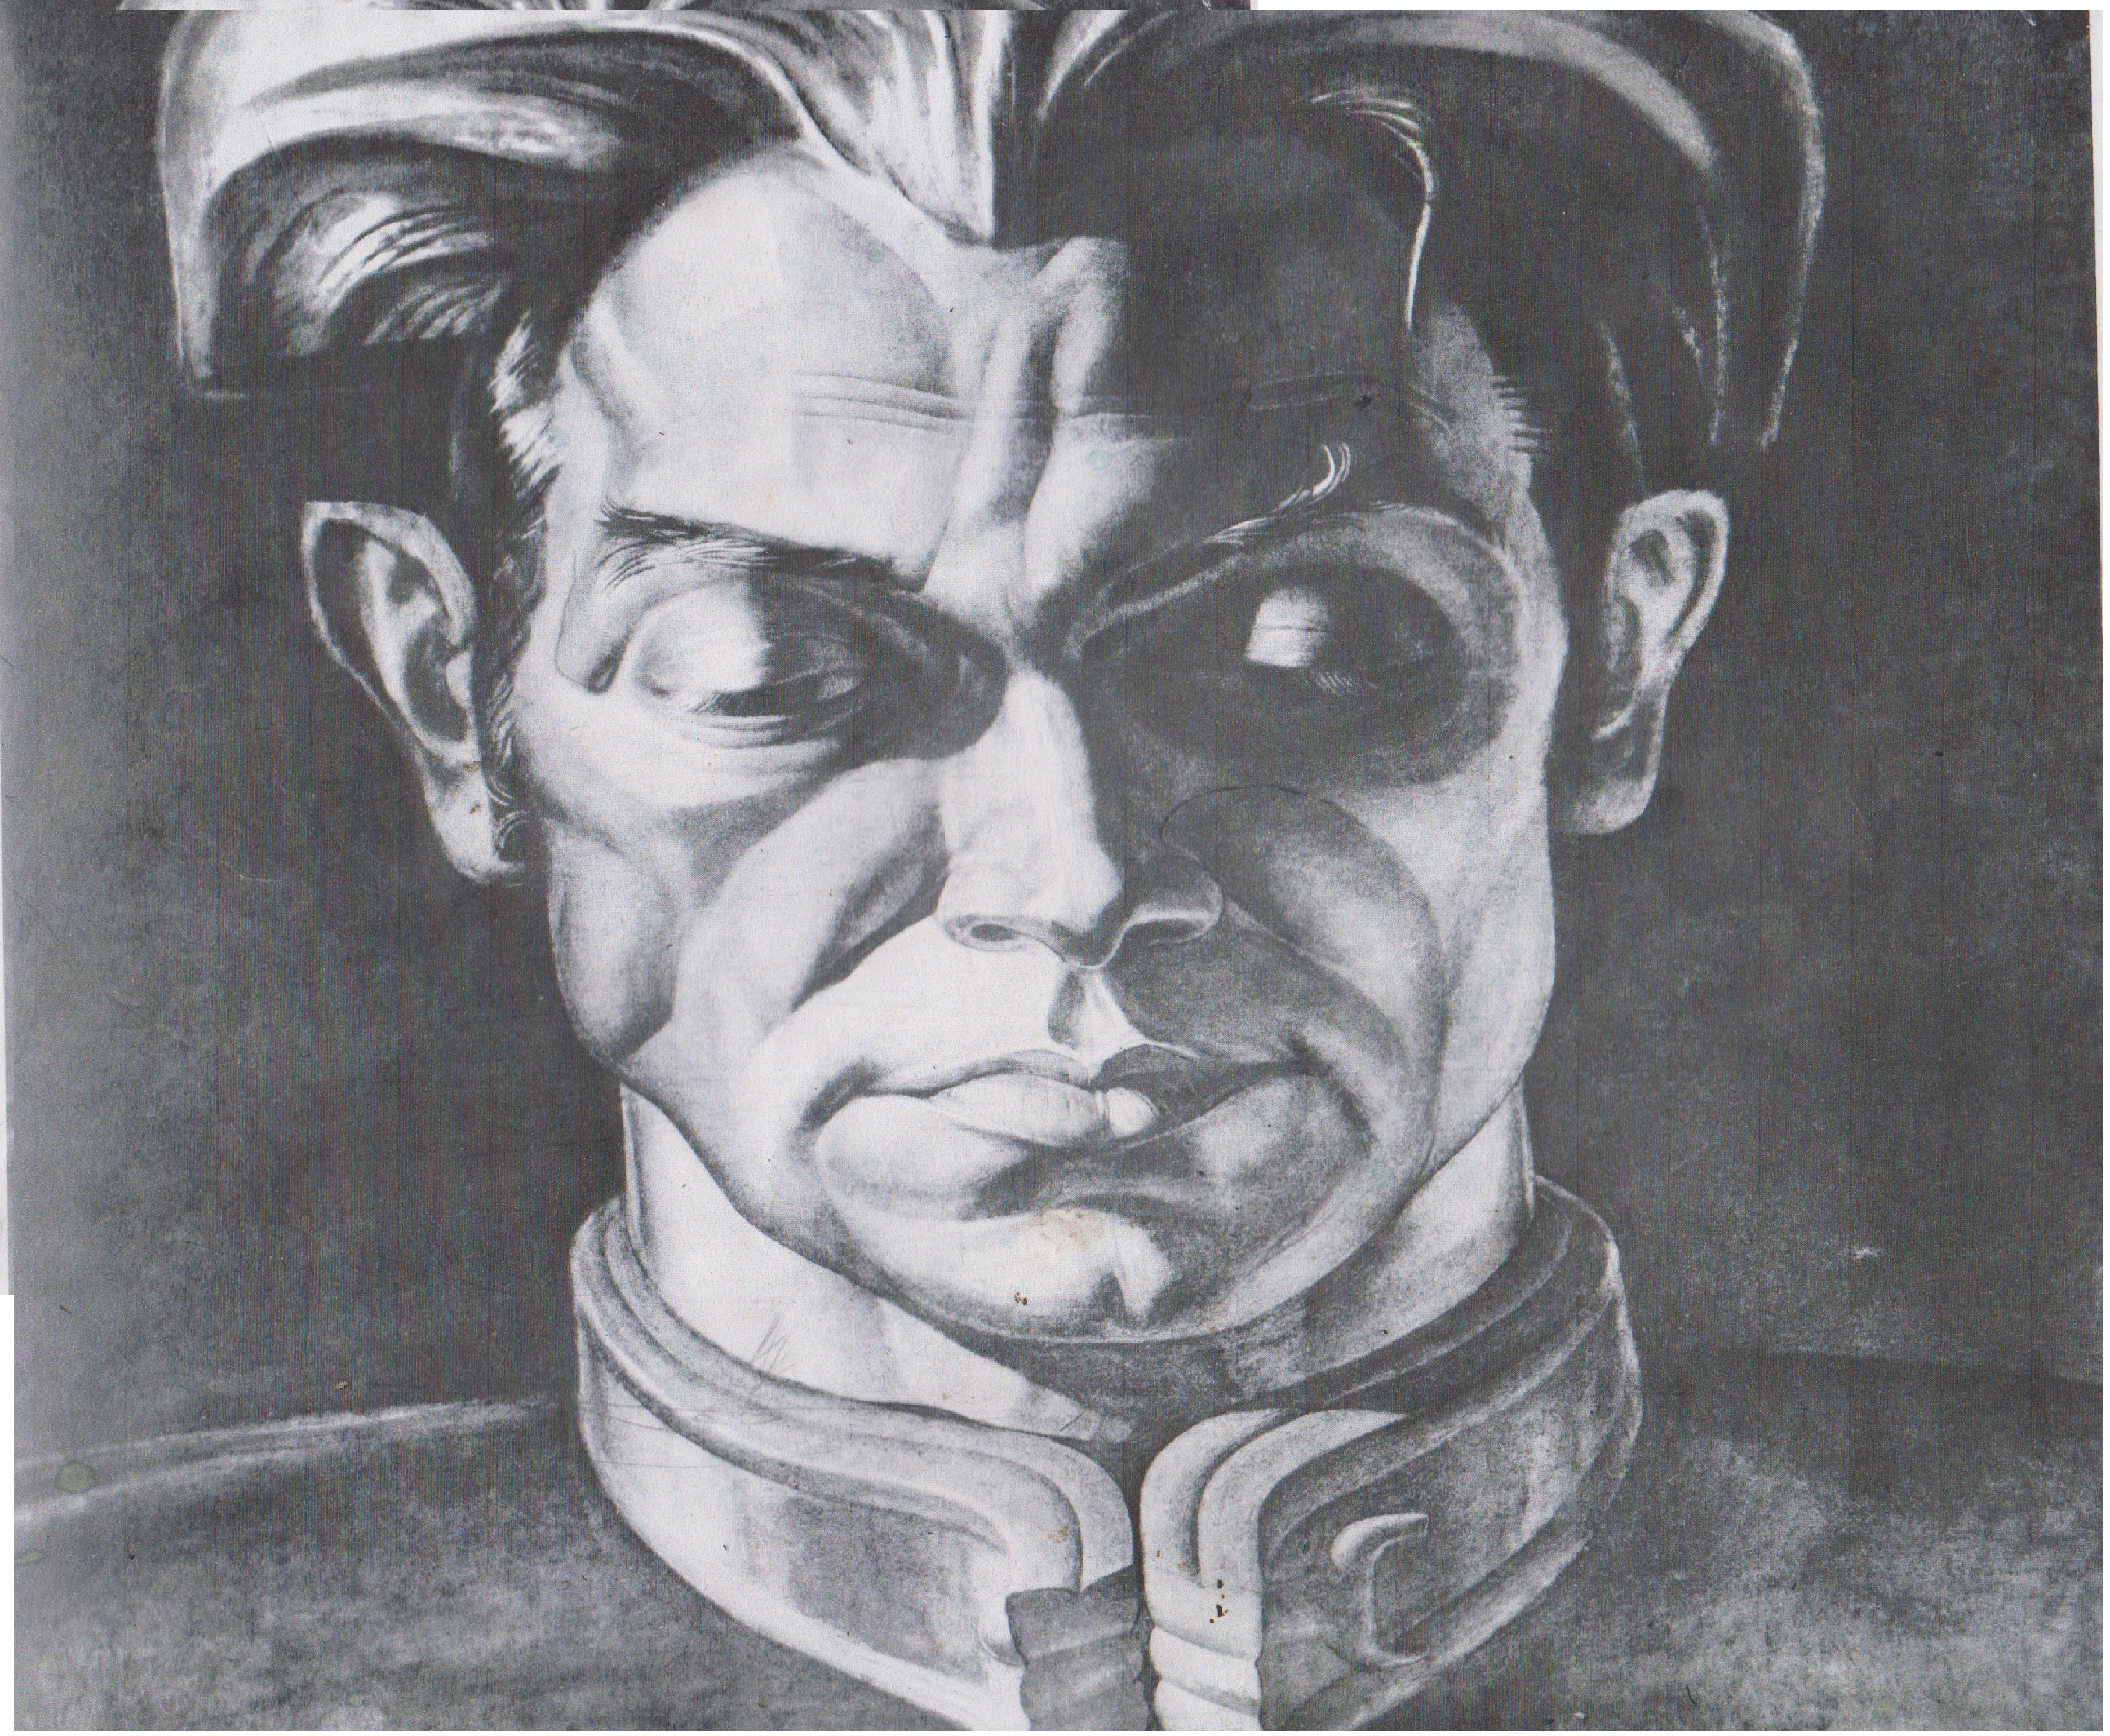

In [ ]:
display(Image(base_image_path))
display(Image(style_reference_image_path))

In [ ]:
def preprocess(image_path):
  img = keras.preprocessing.image.load_img(
      image_path,target_size=(img_nrows,img_ncols))
  img = keras.preprocessing.image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)
  return tf.convert_to_tensor(img)


In [ ]:
def reprocecess(x):
  x = x.reshape((img_nrows,img_ncols,3))
  x[:,:,0] += 103.939
  x[:,:1] += 116.779
  x[:,:,2] += 123.68
  x = x[:,:,::-1]
  x = np.clip(x,0,255).astype("uint8")
  return x

In [ ]:
# The gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))


In [ ]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)


80142336/80134624 [==============================] - 2s 0us/step


In [ ]:
style_layer_names = [
                    "block1_conv1",
                    "block2_conv1",
                    "block3_conv1",
                    "block4_conv1",
                    "block5_conv1",
]

content_layer_name = "block5_conv2"

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += variation_weight  * total_variation_loss(combination_image)
    return loss

In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads



In [ ]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess(base_image_path)
style_reference_image = preprocess(style_reference_image_path)
combination_image = tf.Variable(preprocess(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = reprocecess(combination_image.numpy())
        fname = result + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)


Iteration 100: loss=2125.58
Iteration 200: loss=1741.10
Iteration 300: loss=1582.85


In [ ]:
display(Image(result + "_at_iteration_4000.png"))

NameError: ignored